# Exercise4

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/taipeitechmmslab/MMSLAB-TF2/blob/master/Exercise/Exercise4.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/taipeitechmmslab/MMSLAB-TF2/blob/master/Exercise/Exercise4.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Import

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

### TensorFlow Datasets

安裝：

```
pip install tensorflow-datasets
```
or 

```
pip install git+https://github.com/tensorflow/datasets.git
```



顯示TensorFlow Datasets目前提供的數據集

In [ ]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

### 讀取數據並分析
載入Cifar10數據集

In [ ]:
# 將train Data重新分成9:1等分，分別分給train data, valid data
train_split, valid_split = ['train[:90%]', 'train[90%:]']
# 取得訓練數據，並順便讀取data的資訊
train_data, info = tfds.load("cifar10", split=train_split, with_info=True)
# 取得驗證數據
valid_data = tfds.load("cifar10", split=valid_split)
# 取得測試數據
test_data = tfds.load("cifar10", split="test")

顯示Cifar10數據集資訊

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



Cifar10的十個標籤

In [ ]:
labels_dict = dict(enumerate(info.features['label'].names))
labels_dict

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

查看訓練資料，並計算每個類別的數量：

In [ ]:
# 建立一個dict用來計數每個類別標籤數量
train_dict = {}
# 讀取整個訓練資料集
for data in train_data:
    # 將讀取到的label轉乘numpy格式
    label = data['label'].numpy()
    # 以label沒dict的key，取出dict中的值+1，如果key在dict中沒有值預設為0
    train_dict[label] = train_dict.setdefault(label, 0) + 1
    # train_dict.setdefault(label, 0) + 1
print(train_dict)

{7: 4500, 8: 4456, 4: 4497, 6: 4505, 5: 4503, 2: 4522, 9: 4453, 3: 4526, 0: 4530, 1: 4508}


顯示數據集部分影像資料：

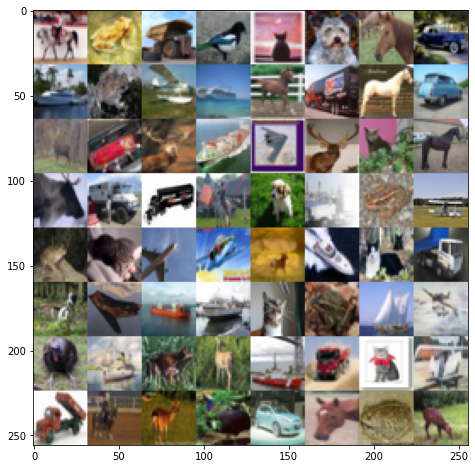

In [ ]:
# 建立一個顯示影像的陣列
output = np.zeros((32 * 8, 32 * 8, 3), dtype=np.uint8)
row = 0
# 每一次取8比資料，共取8次，所以總共取得64比資料
for data in train_data.batch(8).take(8):
    # 將取得的8比堆疊起來，放入顯示影像陣列第N列中
    output[:, row*32:(row+1)*32] = np.vstack(data['image'].numpy())
    row += 1
# 設定顯示視窗大小
plt.figure(figsize=(8, 8))
# 顯示影像
plt.imshow(output)

### 影像增強(Image Augmentation)

取一張影像作為測試使用

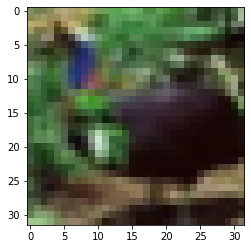

In [ ]:
x = 3
y = 7
image_test = output[y*32:(y+1)*32, x*32:(x+1)*32, :]
plt.imshow(image_test)

水平翻轉：

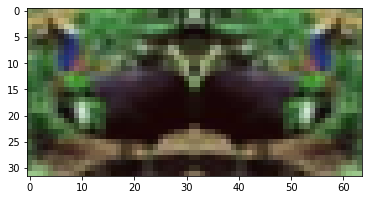

In [ ]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像
    return x

image_2 = flip(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

顏色轉換：

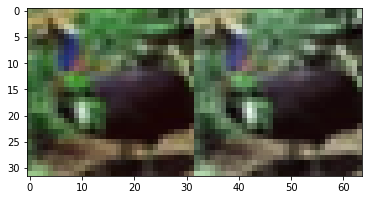

In [ ]:
def color(x):
    """
     Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.7, 1.3)  # 隨機調整影像對比度
    return x


image_2 = color(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

影像旋轉：

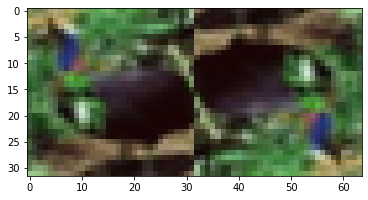

In [ ]:
def rotate(x):
    """
    Rotation image(影像旋轉)
    """
    # 隨機選轉n次(通過minval和maxval設定n的範圍)，每次選轉90度
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

image_2 = rotate(image_test)
image = np.hstack((image_test, image_2))
plt.imshow(image)

影像縮放：

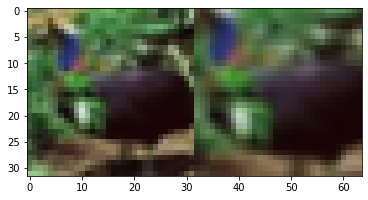

In [ ]:
def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # 隨機縮放比例
    sh = h * scale  # 縮放後影像長度
    sw = w * scale  # 縮放後影像寬度
    x = tf.image.resize(x, (sh, sw))  # 影像縮放
    x = tf.image.resize_with_crop_or_pad(x, h, w)  # 影像裁減和填補
    return x

image_2 = zoom(image_test)
# 因為處理後影像會變成float型態，所以需轉換回來不然顯示時會出現問題
image_2 = tf.cast(image_2, dtype=tf.uint8)
image = np.hstack((image_test, image_2))  # 將原始圖和處理後水平合併
plt.imshow(image)


### Dataset 設定 (Augmentation)

重新載入一次Dataset(因為前面已經對Dataset設定過了)

In [ ]:
train_data = tfds.load("cifar10", split=train_split)

資料愈處理(Data Prepossessing ):
-	標準化：將影像全部除以255，將像素值縮放到0~1之間。
-	影像增強：將影像水平翻轉、影像旋轉、顏色轉換和影像縮放。
-	標籤資料：做One-hot Encoding，例如類別2為[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]。


In [ ]:
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255.
    y = tf.one_hot(dataset['label'], 10)
    return x, y

In [ ]:
def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['image'], tf.float32) / 255.  # 影像標準化
    x = flip(x)  # 隨機水平翻轉
    #========================= Write your code here ========================= #
    # 觸發顏色轉換機率30%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.7, lambda: color(x), lambda: x)
    # 觸發影像旋轉機率30%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.7, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    # 將輸出標籤轉乘One-hot編碼
    y = tf.one_hot(dataset['label'], 10)
    #======================================================================== #
    return x, y

Dataset設定：

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小
train_num = int(info.splits['train'].num_examples / 10) * 9  # 訓練資料數量

# 打散資料集
train_data = train_data.shuffle(train_num)
# 載入預處理「parse_aug_fn」function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟（暫存空間為自動調整模式）
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

測試Dataset經過Augmentation後的結果

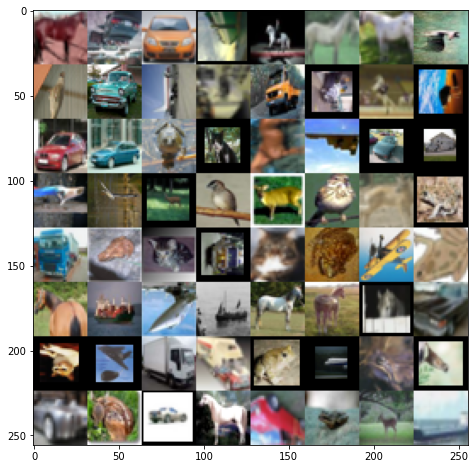

In [ ]:
# 由於前面已經將train_data batch size設定為64，所以取一次資料就有64筆
for images, labels in train_data.take(1):
    images = images.numpy()
# 建立一個顯示影像的陣列
output = np.zeros((32 * 8, 32 * 8, 3))
# 將64筆資料分別放入顯示影像的陣列
for i in range(8):
    for j in range(8):
        output[i*32:(i+1)*32, j*32:(j+1)*32, :] = images[i*8+j]
plt.figure(figsize=(8, 8))
# 顯示影像
plt.imshow(output)

### 訓練Model（使用影增強方法訓練卷積神經網路）

建立網路模型，這邊使用到以下幾種網路層：
- keras.Input：輸入層(輸入影像大小為32x32x3)
- layers.Conv2D：卷積層(使用ReLU激活函數，以及3x3大小的kernel)
- layers.MaxPool2D：池化層(對特徵圖下採樣)
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)
- layers.Dropout：Dropout層(每次訓練隨機丟棄50%網路)
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [ ]:
# 建立輸入層
inputs = keras.Input(shape=(32, 32, 3))
#========================= Write your code here ========================= #
# 第1層convolution層，filters=64, kernel_size=5x5, relu activation function
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
# 第2層MaxPool2D層
x = layers.MaxPool2D()(x)
# 第3層convolution層，filters=128, kernel_size=3x3, relu activation function
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
# 第4層convolution層，filters=128, kernel_size=3x3, relu activation function
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
# 第5層convolution層，filters=64, kernel_size=3x3, relu activation function
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
# 第6層Flatten層
x = layers.Flatten()(x)
# 第7層全連接層，unit=32, relu activation function
x = layers.Dense(32, activation='relu')(x)
# 第8層Dropout層，捨棄比率設定為30%
x = layers.Dropout(0.3)(x)
# 最後一層全連接層，輸出維度為類別數量，並且使用sigmoid激活函數
outputs = layers.Dense(10, activation='softmax')(x)
#======================================================================== #

# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model = keras.Model(inputs, outputs, name='model')
model.summary()  # 顯示網路架構

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          73792     
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0     

創建模型儲存目錄：

In [ ]:
model_dir = 'lab4-logs/models/'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

建立Callback function：

In [ ]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab4-logs', 'model')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model.hdf5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

設定訓練使用的優化器、損失函數和指標函數

In [ ]:
model.compile(
    # optimizers使用Adam(0.001)
    keras.optimizers.Adam(0.001), 
    # loss使用Categorical Crossentropy
    loss=keras.losses.CategoricalCrossentropy(), 
    # metrics使用Categorical Accuracy
    metrics=[keras.metrics.CategoricalAccuracy()]
)

訓練網路模型

In [ ]:
history = model.fit(train_data,
                    epochs=30, 
                    validation_data=valid_data,
                    callbacks=[model_cbk, model_mckp])

Epoch 1/30
704/704 [==============================] - 292s 414ms/step - loss: 2.0961 - categorical_accuracy: 0.2023 - val_loss: 1.8744 - val_categorical_accuracy: 0.3274
Epoch 2/30
704/704 [==============================] - 288s 410ms/step - loss: 1.9048 - categorical_accuracy: 0.2806 - val_loss: 1.5953 - val_categorical_accuracy: 0.4088
Epoch 3/30
704/704 [==============================] - 287s 407ms/step - loss: 1.7807 - categorical_accuracy: 0.3349 - val_loss: 1.4400 - val_categorical_accuracy: 0.4862
Epoch 4/30
704/704 [==============================] - 288s 409ms/step - loss: 1.6860 - categorical_accuracy: 0.3718 - val_loss: 1.3775 - val_categorical_accuracy: 0.5176
Epoch 5/30
704/704 [==============================] - 286s 405ms/step - loss: 1.6310 - categorical_accuracy: 0.3948 - val_loss: 1.2814 - val_categorical_accuracy: 0.5302
Epoch 6/30
704/704 [==============================] - 288s 410ms/step - loss: 1.5722 - categorical_accuracy: 0.4142 - val_loss: 1.2337 - val_categoric

驗證在測試集上：

In [ ]:
loss, acc = model.evaluate(test_data)
print('\nModel Accuracy: {}%'.format(acc))

157/157 [==============================] - 17s 104ms/step - loss: 0.8184 - categorical_accuracy: 0.7176

Model Accuracy: 0.7175999879837036%


讀取各自最佳的網路權重：

In [ ]:
model.load_weights('lab4-logs/models/Best-model.hdf5')
loss, acc = model.evaluate(test_data)

157/157 [==============================] - 15s 98ms/step - loss: 0.8184 - categorical_accuracy: 0.7176


驗證在測試集數據上：

In [ ]:
loss, acc = model.evaluate(test_data)

157/157 [==============================] - 15s 97ms/step - loss: 0.8184 - categorical_accuracy: 0.7176
